In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pylab as plt

import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

from IPython.display import display

In [2]:
df = pd.read_excel("Задания_1_2.xlsx", sheet_name="Timeseries")
df["Date"] = pd.to_datetime(df["Date"])

df.head()


,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892


In [3]:
df.describe()


,series1
count,1642.000000
mean,3854.975154
std,1237.337605
min,236.870506
25%,3138.534200
50%,3632.014420
75%,4258.734299
max,12652.832842


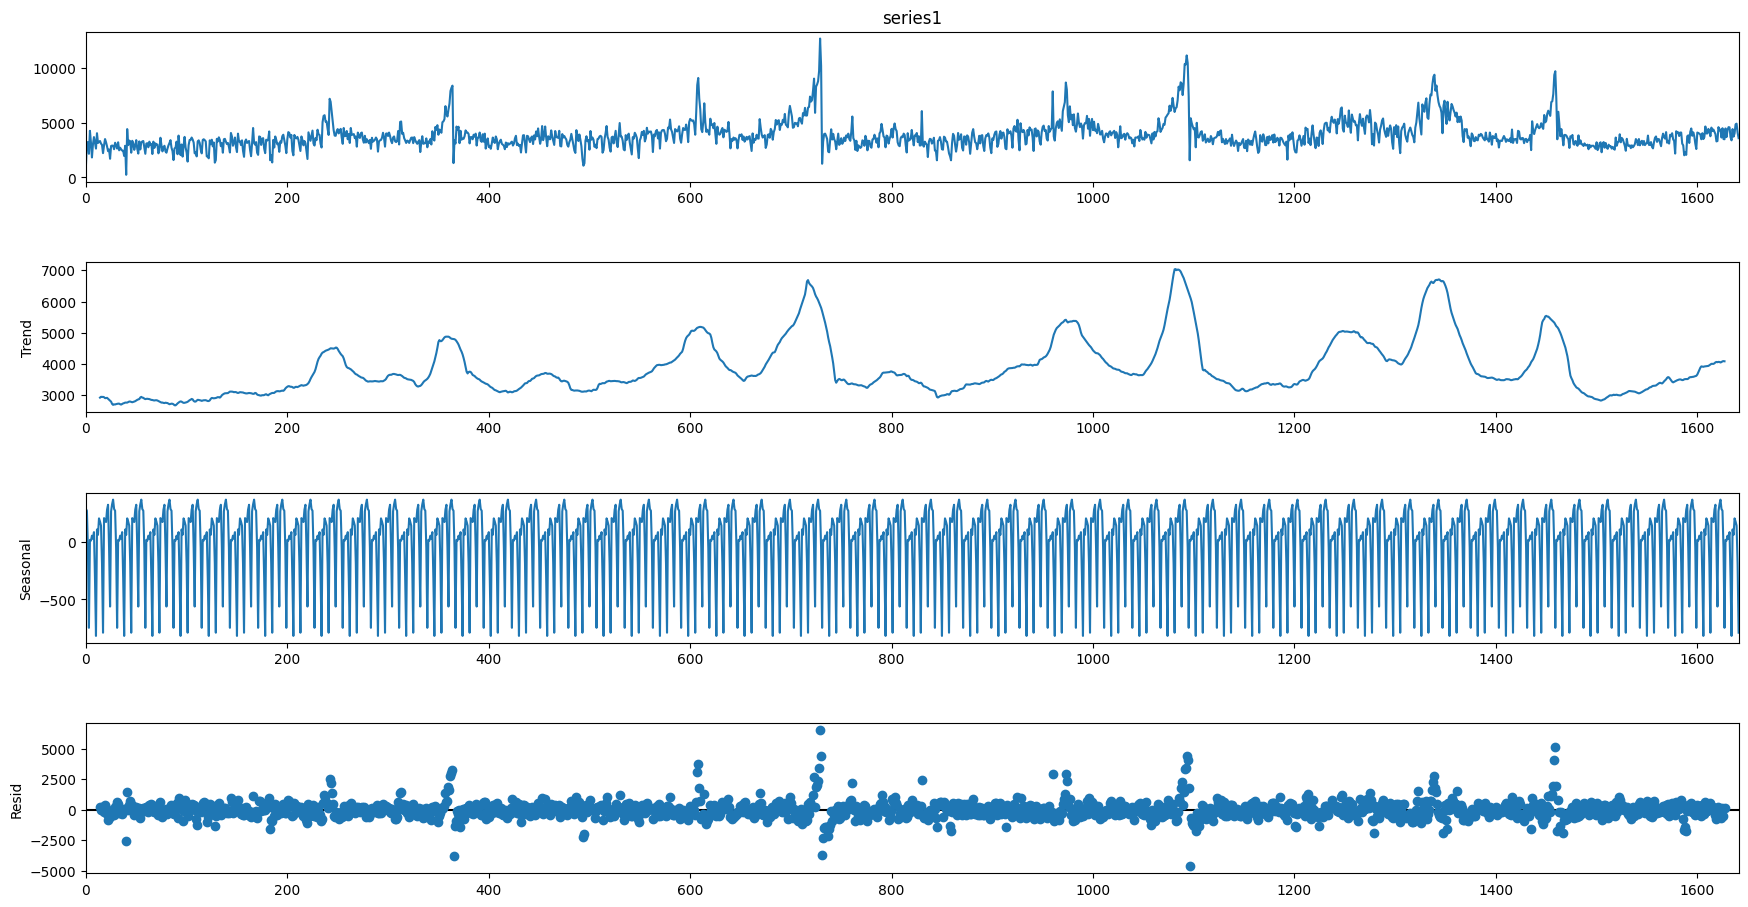

In [4]:
# проверим на сезонность
res = sm.tsa.seasonal_decompose(df.series1.dropna(), period=28)
fig = res.plot()
fig.set_figheight(10)
fig.set_figwidth(20)
plt.show()


In [5]:
# функция для расширения датафрейма путём добавления дополнительных данных
def make_df(df):
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['week'] = df['Date'].dt.week
    df['weekofyear'] = df['Date'].dt.weekofyear
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['weekday'] = df['Date'].dt.weekday
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['quarter'] = df['Date'].dt.quarter

    df['is_month_start'] = df['Date'].dt.is_month_start.astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df['Date'].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df['Date'].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df['Date'].dt.is_year_start.astype(int)
    df['is_year_end'] = df['Date'].dt.is_year_end.astype(int)
    return df


In [6]:
# добавляем 3 месяца для будущего предсказания
df_pred_next_3 = df["Date"]+pd.DateOffset(months=3)
df_pred_next_3 = pd.DataFrame(df_pred_next_3, columns=["Date"])
df_pred_next_3 = make_df(df_pred_next_3.sort_values(
    by="Date", ascending=True).set_index("Date").last("3M").reset_index())
df_pred_next_3.set_index("Date", inplace=True)
df_pred_next_3.head()


,year,month,day,week,weekofyear,dayofweek,weekday,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
Date,,,,,,,,,,,,,,,
2019-07-01,2019,7,1,27,27,0,0,182,3,1,0,1,0,0,0
2019-07-02,2019,7,2,27,27,1,1,183,3,0,0,0,0,0,0
2019-07-03,2019,7,3,27,27,2,2,184,3,0,0,0,0,0,0
2019-07-04,2019,7,4,27,27,3,3,185,3,0,0,0,0,0,0
2019-07-05,2019,7,5,27,27,4,4,186,3,0,0,0,0,0,0


In [7]:
df = make_df(df)
df.head()


,Date,series1,year,month,day,week,weekofyear,dayofweek,weekday,dayofyear,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2015-01-01,1006.699649,2015,1,1,1,1,3,3,1,1,1,0,1,0,1,0
1,2015-01-02,3197.751826,2015,1,2,1,1,4,4,2,1,0,0,0,0,0,0
2,2015-01-03,3217.491035,2015,1,3,1,1,5,5,3,1,0,0,0,0,0,0
3,2015-01-04,2151.573759,2015,1,4,1,1,6,6,4,1,0,0,0,0,0,0
4,2015-01-05,4243.929892,2015,1,5,2,2,0,0,5,1,0,0,0,0,0,0


In [8]:
df.set_index("Date", inplace=True)


In [9]:
# избавимся от сезонности
window = 28

df["diff"] = df["series1"] - df["series1"].rolling(window).mean().shift(1)
df.dropna(inplace=True)


In [10]:
X = df.drop(labels=['series1', 'diff'], axis=1)
y = df['diff']


In [11]:
tss = TimeSeriesSplit(n_splits=4)
for train_index, test_index in tss.split(X):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


In [12]:
# создаем регерссионную модель
reg = RandomForestRegressor(
    n_estimators=320, min_samples_leaf=2, max_features="sqrt", n_jobs=-1, oob_score=True)
display(reg.fit(X_train, y_train))
print("Out-of-bag R2 score: %.2f%%" % (100 * reg.oob_score_))


RandomForestRegressor(max_features='sqrt', min_samples_leaf=2, n_estimators=320,
                      n_jobs=-1, oob_score=True)

Out-of-bag R2 score: 70.53%


In [13]:
predictions = reg.predict(X_test)


In [14]:
pred_df = pd.DataFrame(zip(y_test.index, predictions),
                       columns=["Date", "diff"])
pred_df.set_index("Date", inplace=True)


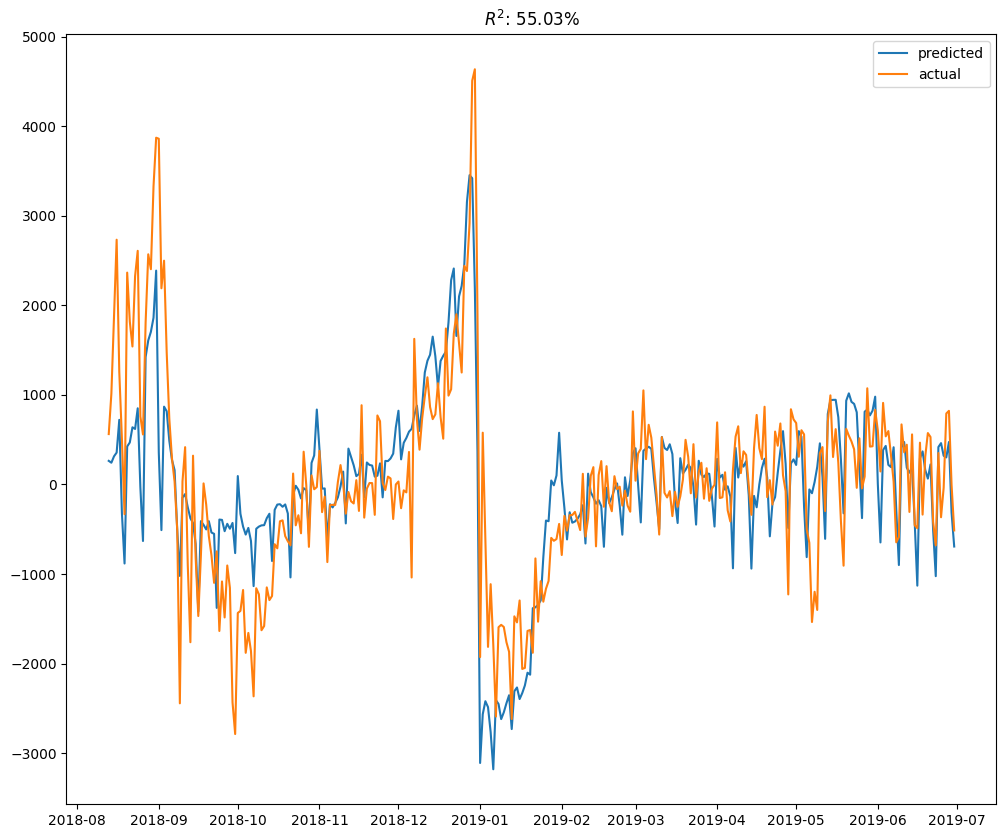

In [15]:
# выводим на графике предсказанные и известные значения
plt.figure(figsize=(12, 10))
plt.plot(pred_df, label="predicted")
plt.plot(y_test, label="actual")
r2 = r2_score(y_test, pred_df["diff"]) * 100
plt.title("$R^2$: %.2f%%" % r2)
plt.legend()
plt.show()


In [16]:
# предсказываем следующие 3 месяца 
preiction_next_3 = reg.predict(df_pred_next_3)


In [17]:
result_df = pd.DataFrame(
    zip(df_pred_next_3.index, preiction_next_3), columns=["Date", "diff"])
result_df.head()


,Date,diff
0,2019-07-01,76.504505
1,2019-07-02,-544.336158
2,2019-07-03,-305.859848
3,2019-07-04,57.293337
4,2019-07-05,-38.698170


In [18]:
# функция для перевода данных в исходный вид
def cumsum_shift(s, shift=1, init_values=[0]):
    s_cumsum = pd.Series(np.zeros(len(s)))
    for i in range(shift):
        s_cumsum.iloc[i] = init_values[i]
    for i in range(shift, len(s)):
        s_cumsum.iloc[i] = s_cumsum.iloc[i-shift] + s.iloc[i]
    return s_cumsum


In [19]:
win_size = 28
result_df['series1'] = cumsum_shift(
    s=result_df["diff"], shift=win_size, init_values=df['series1'].values[:win_size])
result_df.head()


,Date,diff,series1
0,2019-07-01,76.504505,2566.097144
1,2019-07-02,-544.336158,3158.273408
2,2019-07-03,-305.859848,2921.402903
3,2019-07-04,57.293337,2625.314771
4,2019-07-05,-38.698170,3197.751826


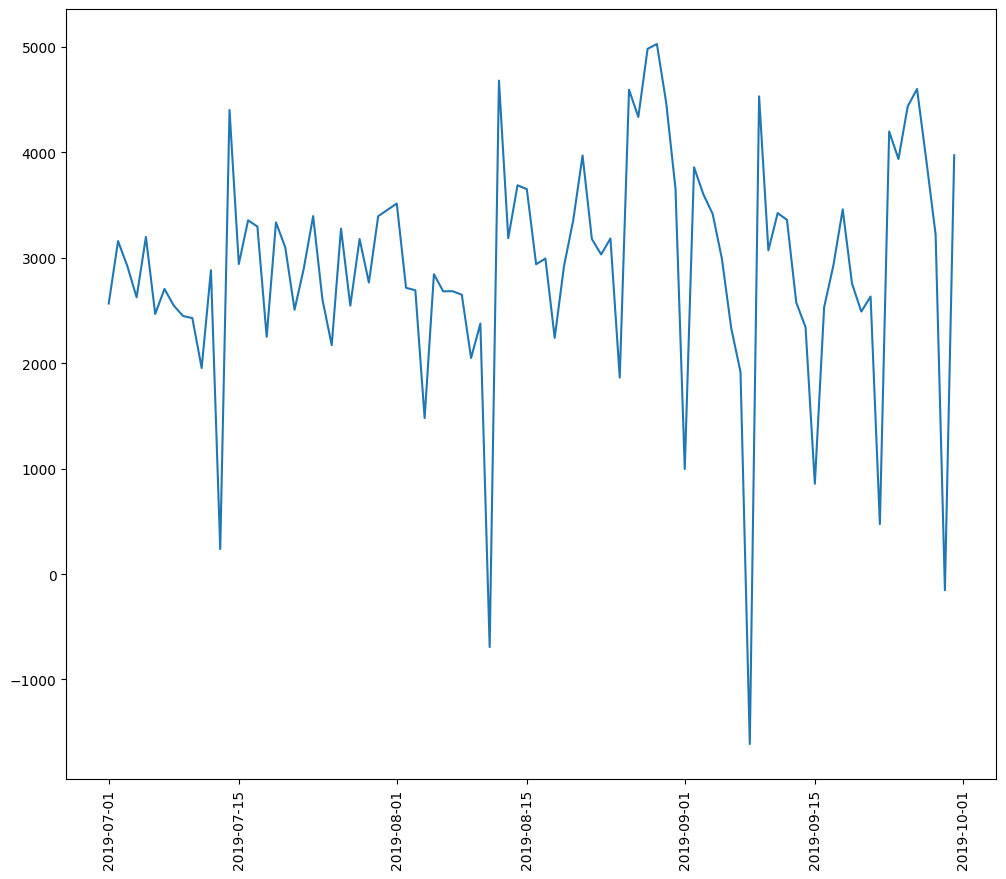

In [20]:
# выводим график предсказанных значений
plt.figure(figsize=(12, 10))
plt.plot(result_df['Date'], result_df['series1'])
plt.xticks(rotation='vertical')
plt.show()


In [21]:
result_df = result_df.drop(labels=['diff'], axis=1)
result_df.head()


,Date,series1
0,2019-07-01,2566.097144
1,2019-07-02,3158.273408
2,2019-07-03,2921.402903
3,2019-07-04,2625.314771
4,2019-07-05,3197.751826


In [22]:
# cохраняем данные
result_df.to_csv("predict_timeseries.csv", index=False)
